# Introduction to ARMA Models with Financial Data

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
import numpy as np

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error



We can use the yfinance package in python which uses Yahoo's publicly available API to pull data. We will pull the data for the S&P 500 using the ticker $SPY. We do this by creating a ticker object for spy. Once we have our ticker object (spy) we can access methods or attributes of the object such as history. The history method will allow us to pull historical data by defining some parameters including: 

- period: "1d”, “5d”, “1mo”, “3mo”, “6mo”, “1y”, “2y”, “5y”, “10y”, “ytd”, “max”
- interval: “1m”, “2m”, “5m”, “15m”, “30m”, “60m”, “90m”, “1h”, “1d”, “5d”, “1wk”, “1mo”, “3mo”
- start: formatted as (yyyy-mm-dd) or datetime.
- end: formatted as (yyyy-mm-dd) or datetime.

Below we use the period and interval to define how far back we want the data and at what intervals from that period to current we want the data. Otherwise, we could also define start and end instead of period. 

In [3]:
spy = yf.Ticker("SPY")
# hist = spy.history(period = "1y", interval= "1d")
hist = spy.history(start = "2010-01-04", end = "2020-02-01")
df = pd.DataFrame(hist, columns=['Close'])
df.head

<bound method NDFrame.head of                                 Close
Date                                 
2010-01-04 00:00:00-05:00   88.117912
2010-01-05 00:00:00-05:00   88.351135
2010-01-06 00:00:00-05:00   88.413391
2010-01-07 00:00:00-05:00   88.786545
2010-01-08 00:00:00-05:00   89.082024
...                               ...
2020-01-27 00:00:00-05:00  307.216370
2020-01-28 00:00:00-05:00  310.435791
2020-01-29 00:00:00-05:00  310.179291
2020-01-30 00:00:00-05:00  311.185974
2020-01-31 00:00:00-05:00  305.535522

[2537 rows x 1 columns]>

To begin any data analysis of time series data, it is useful to look at the trace plot, a historical plot of stock prices over time. 

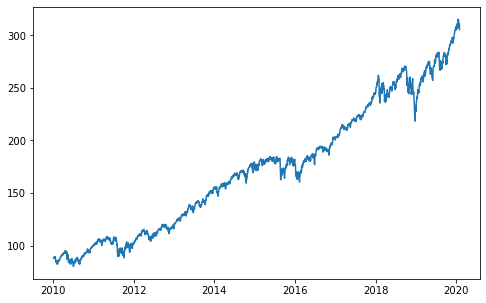

In [4]:
# add trace plot
plt.figure(figsize=(8,5))
plt.plot(df['Close'])

## Stationarity

In order for stationarity to be satsifed the following must be true: 

1) $E[X+t]$ does not depend on t. Thus there is constant mean. 

2) $var(X+t)$ does not depend on t. Thus there is constant variance.

3) $cov(X_t, X_{t+h})$ does not depend on t but only on $|{s-t}|$. That is, it only depends on the difference in times and not on the time itself. 

We can see in the above trace plot that stationarity is not satisfied. This is problematic in time series data because stationarity allows us to make valid statistical inferences about the time series data and leverage classical forecasting models such as ARIMA. 

There are methods we can employ to ensure stationarity such as differencing our data. Currently, our data are represented as $X_t$ where each time point has a stock price at close associated with it. However, we may be interested in differencing our data in order to achieve stationarity. For this, we are essentially subtracting the current observation by the previous in the following format to give us a new time series $Y_t$; 

$Y_t = X_t - X_{t-1}$

We can see that differencing removed any noticable trends or patterns in the plots below. As well, we could use a more fomal test, the Augmented Dickey-Fuller (ADF) Test to test a null hypothesis that the series is not stationary versus the alternative hypothesis that the series is stationary. This test confirms our visual results for the differenced data. 

Text(0, 0.5, 'difference price')

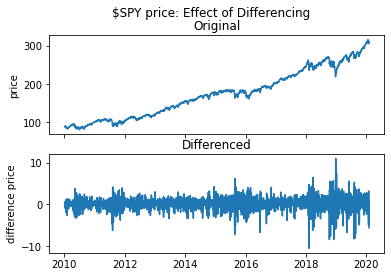

In [5]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('$SPY price: Effect of Differencing')

ax1.plot(df['Close'])
ax1.set_ylabel('price')
ax1.set_title('Original')

ax2.plot(df['Close'].diff())
ax2.set_title("Differenced")
ax2.set_ylabel('difference price')

In [6]:
from statsmodels.tsa.stattools import adfuller

def ADF_Cal(x):
    result = adfuller(x)
    ADF_stat = result[0]
    p = result[1]
    print("ADF Statistic: %f" % ADF_stat)
    print("p-value: %f" % p)
    print("Critical Values")
    levels = [.01, .05, .1]
    i = 0
    for key,value in result[4].items():
        print('\t%s: %.3f' % (key,value))
        hyp = p < levels[i]
        if ADF_stat < value:
            cert = (1-levels[i])*100
            print('Reject H0: {}'.format(hyp))
            break
        i = i+1
        if i >= 3:
            print("Less than 90% certain that data is stationary")
            print('Reject H0: {}'.format(hyp))
print("Calculating ADF test for X...")

ADF_Cal(df['Close'].diff()[1:])

Calculating ADF test for X...
ADF Statistic: -11.415870
p-value: 0.000000
Critical Values
	1%: -3.433
Reject H0: True


## ACF & PACF Plots
We can use ACF, PACF and EACF Plots to give us an approximation of  an appropriate ARMA(p,q) model for the data. 

**ACF and PACF**

ACF is the autocovariance of lag h. Recall, for a stationary time series the covariance of difference time periods msut not depend on t but on |s - t|. That is, it is consistent between specific lags, *h*, which we define as |s-t|. 

$\gamma(h) = Cov(X_t, X_{t+h})$

So, if we want the autocovariance between observations $X_t$ and $X_{t-1}$ this is equivalent to: 

$\gamma(1) = Cov(X_t, X_{t-1})$ and we would expect this value to be there same between all observations which are 1 time unit (lag = 1) apart.  

PACF is the partial autocorrelation of lag h. The partial autocorrelation at lag *h* is the correlation between the time series data point at lag k and the same data point lagged by *h* time units, while controlling for the influence of all other data points between them.  For example, at lag 3, partial autocorrelation removes the effect lags 1 and 2 have on computing the correlation. We can roughly use the visual cues below to determine what appropriate cutoffs for our ARMA() model would be. 


|          | AR(p)               | MA(q)                 | ARMA(p,q)|
| :------: | :------:            | :------:              | :------: |
|     ACF  | tails off           | cuts off after lag q  | tails off|
|    PACF  |cuts off after lag p | tails off             | tails off|         

/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


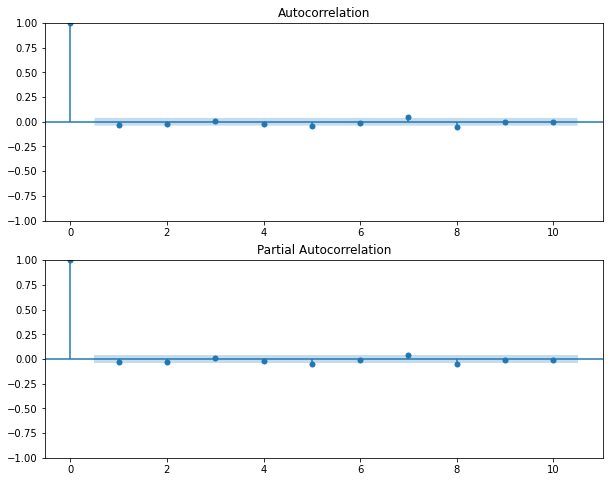

In [7]:
# Plot ACF and PACF
diff_ts = df['Close'].diff()[1:]
diff_ts

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_ts, ax=ax1, lags = 10)
plot_pacf(diff_ts, ax=ax2, lags = 10)
plt.show()

## ARMA Model Fitting

We will fit an appropriate ARMA(p,q) model based on the above and the automated process of python's pmdarima auto_arima function. An ARMA(p,q) model has two components: AR(p) and MA(q). 

AR(p) refers to the autoregressive nature of the data. In the simplest case, this is equivalent to $X_t = \phi X_t-1 + W_t$. This model assigns weight $\phi$ to a previous observation and adds noise $W_t$, which generally we assume to be normally distributed. If we have several orders of the autoregressive component (p >=1), we can define the coefficients $phi_{1:n}$ within a characteristic polynomial such as: 

$X_t = \phi _1 X_{t-1} + ... +  \phi _pX_{t-p}$ can be rewritten as $\phi (B)X_t$ where $\phi(Z) = 1 -\sum_{j=1}^p  \phi _j z ^j$

With an example of an order 2, p = 2, ARMA(2) process below: 

$X_t = \phi _1 X_{t-1} + \phi _2 X_{t-2} + W_t$ which can be rewritten as $\phi (B)X_t$ where $\phi(Z) = 1 -\sum_{j=1}^2  \phi _j z ^j$ 


MA(q) refers to the moving average component of the data. In the simplest case we have $X_t = \theta W_{t-1} + W_t$. This model essentailly takes the average over a sliding window.If we have several orders of the moving average component (q >=1), we can define the coefficients $theta_{1:n}$ within a characteristic polynomial such as: 

$X_t = W_t +\theta _1 W_{t-1} + ... +  \theta _qX_{t-q}$ can be rewritten as $\theta (B)X_t$ where $\theta(Z) = 1 +\sum_{j=1}^p  \theta _j z ^j$


Combining the above, we reach the ARMA(p,q) model as follows: 

$X_t = \phi _1 X_{t-1} + ... + \phi _p X_{t-p} + W_t + \theta _1 W_{t-1} + ... +  \theta _qX_{t-q}$

which is equivalent to the following using characteristic polynomial notation as outlined above for AR(p) and MA(q) processes as 

$\phi(B) X_t = \theta(B)W_t$  

It is important to not that the differencing operation we applied to the data makes our ARMA(p,q) model on the differenced data series equivalent to running an ARIMA(p,d,q) model on the original data - where d is the order of differencing, 1 in this case. 

In [8]:
# train test split
y_train, y_test = train_test_split(df, train_size= 0.8)

# fit model
model=pm.auto_arima(y_train,start_p=0,d=1,start_q=0,
          max_p=5,max_d=1,max_q=5, start_P=0,
          D=0, start_Q=0, max_P=5,max_D=0,
          max_Q=5, seasonal=False,
          error_action='warn',trace=True,
          supress_warnings=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6573.273, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6573.369, Time=0.09 sec


/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6573.364, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6580.889, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6574.629, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.675 seconds


/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [9]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2029
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -3284.636
Date:                Tue, 28 Mar 2023   AIC                           6573.273
Time:                        18:56:35   BIC                           6584.502
Sample:                             0   HQIC                          6577.393
                               - 2029                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0843      0.028      3.045      0.002       0.030       0.139
sigma2         1.4939      0.030     49.504      0.000       1.435       1.553
===================================================================================
Ljung-Box (L1) (Q):                   1.91   Jarque-Bera (JB):               837.72
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Estimated Model and Interpetation 

We see from the automated process above, as well as from our ACF and PACF plots which show very little lagged patterns, that a parsimonious ARMA(p,q) model is most appropriate. Our results support previous findings in financial modeling literature which have confirmed that the most parsimonious ARMA(p,q) models and random walk models outperform other complex modeling processes (including deep learning models) with regularity. [insert reference]

Since the data is differenced, this ARIMA(0,1,0) equivalent to a random walk model since $X_t - X_{t-1} = Y_t$ and out ARIMA(0,0,0) model is esssentially $Y_t - \mu = W_t$ ?? 

**Model:** 

First we differenced our data resulting in the following: 

$Y_t = X_t - X_{t-1}$ gives our differenced dataset $Y_t$

**ARMA(0,0,0)**

Then we fit onto the differenced data the following: 

$Y_t - 0.0843 = W_t$, where $W_t \sim wn(1.5))$





# Additional Model 

Additionally, we can choose to fit an AR(1) process on the differenced data - or equivalently ARIMA(1,1,0)-  which seems to have performed well according to AIC values. The estimated model for this process is as follows:

$Y_t = X_t - X_t-1$ gives our differenced dataset $Y_t$

$Y_t - 0.0843 = -0.306 (X_t - 0.0843) + W_t$,  where $W_t \sim wn(1.5))$


In [10]:
# fit AR(1) model on train data
ar_mod = ARIMA(y_train, order=(1,1,0))
ar_fit = ar_mod.fit()
print(ar_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2029
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -3288.771
Date:                Tue, 28 Mar 2023   AIC                           6581.543
Time:                        18:56:35   BIC                           6592.772
Sample:                             0   HQIC                          6585.663
                               - 2029                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0258      0.015     -1.742      0.082      -0.055       0.003
sigma2         1.5000      0.030     49.627      0.000       1.441       1.559
Ljung-Box (L1) (Q):                   0.05   Jarque-

/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Diagnostic Plots

We can run the diagnostic plots to check that the ARIMA(0,0,0) model (or random walk model) is appropriate and a good fit to the data. 

We see in the correlogram that there is not significant correlation as most lags $\ge$ 1 fall within the bands. Thus, the time series residuals have low correlation with lagged versions of itself. 

The normal q-q plot shows some deviation from normality at the tail, which is only a bit concerning, but the density plot does show an approximately normal distribution of the residuals. 

We see in the Ljung-Box test from the model output that the probability is 0.17, so we fail to reject the null that the residuals are independtly distributed, which is good and implies i.i.d. 

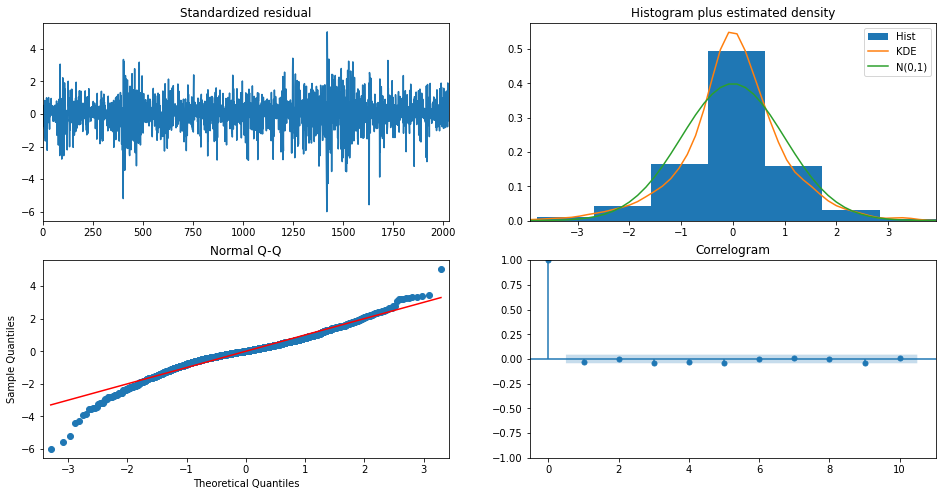

In [11]:
plt.rc("figure", figsize=(16,8))

model.plot_diagnostics()
plt.show()

**AR(1) Model Diagnostics**

We see very much a similar result from the model diagnostics of the AR(1) model. 

We see in the correlogram that there is not significant correlation as most lags $\ge$ 1 fall within the bands. Thus, the time series residuals have low correlation with lagged versions of itself. 

The normal q-q plot shows some deviation from normality at the tail, which is only a bit concerning, but the density plot does show an approximately normal distribution of the residuals. 

We see in the Ljung-Box test from the model output that the probability is 1.00, so we fail to reject the null that the residuals are independtly distributed, which is good and implies i.i.d. 

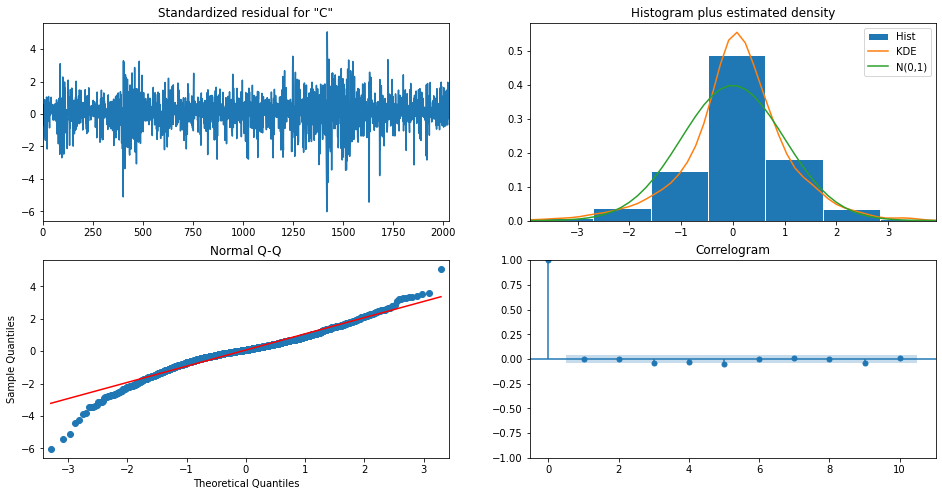

In [16]:
ar_fit.plot_diagnostics()
plt.show()

## Forecasting and Plots

Below we can see the plots for both modeling processes with prediction intervals included: 

1) Random Walk - ARIMA(0,1,0)

2) AR(1) on differenced data - ARIMA (1,1,0) on original

/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


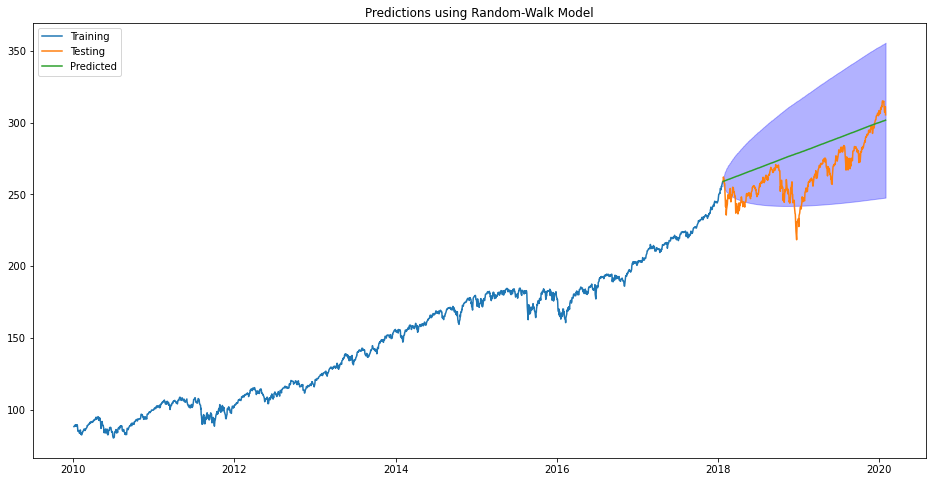

In [13]:
# Random Walk Model 
rw_preds = pd.DataFrame(model.predict(n_periods = y_test.shape[0]))
rw_preds['date'] = y_test.index
rw_preds = rw_preds.set_index('date')
rw_preds.columns = ['predictions']
 
# get CI 
model_pred_ci = model.predict(y_test.shape[0], return_conf_int=True)
pred, ci = model_pred_ci
lower = list(list(zip(*ci))[0])
upper = list(list(zip(*ci))[1])


# make plot of preds
plt.plot(y_train,label="Training")
plt.plot(y_test,label="Testing")

plt.plot(rw_preds['predictions'],label="Predicted")
plt.fill_between(y_test.index, lower, upper, color='blue', alpha=0.3)

plt.legend(loc = 'upper left')
plt.title('Predictions using Random-Walk Model')
plt.show()


/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


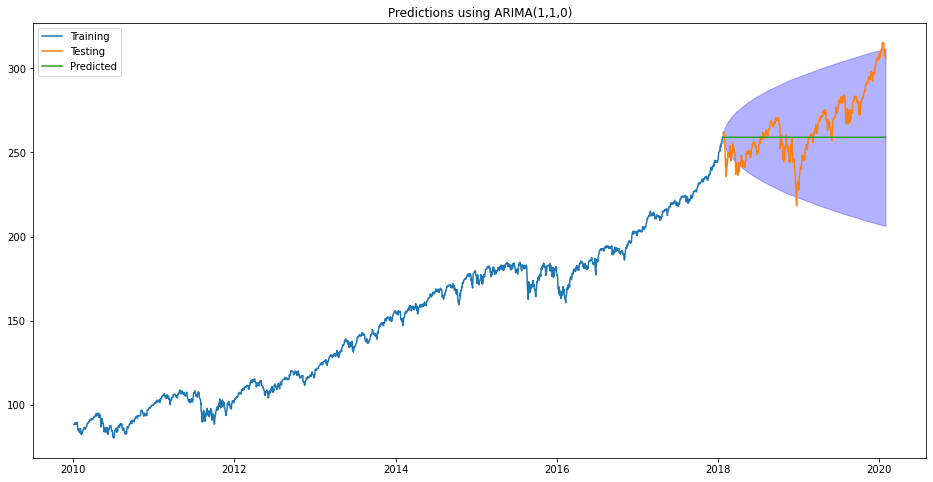

In [14]:
# AR(1) model on diff data or ARIMA(1,1, 0)
ar_preds = pd.DataFrame(ar_fit.forecast(y_test.shape[0]))
ar_preds['date'] = y_test.index
ar_preds = ar_preds.set_index('date')
ar_preds.columns = ['predictions']

# get CI 
ar_pred_ci = ar_fit.get_forecast(y_test.shape[0]).conf_int()
ar_pred_ci['date'] = y_test.index
ar_pred_ci = ar_pred_ci.set_index('date')

# make plot of preds
plt.plot(y_train,label="Training")
plt.plot(y_test,label="Testing")

plt.plot(ar_preds['predictions'],label="Predicted")
plt.fill_between(ar_pred_ci.index, ar_pred_ci.iloc[:,0], ar_pred_ci.iloc[:,1], color='blue', alpha=0.3)

plt.legend(loc = 'upper left')
plt.title('Predictions using ARIMA(1,1,0)')
plt.show()


# Performance Metrics (MAPE and MSE)


In [15]:
data = {'MAPE': [mean_absolute_percentage_error(y_test,ar_preds['predictions']), mean_absolute_percentage_error(y_test,rw_preds['predictions'])],
        'MSE': [mean_squared_error(y_test,ar_preds['predictions']), mean_squared_error(y_test,rw_preds['predictions'])]}

df = pd.DataFrame(data, index = ["AR1", "RW"])

df


,MAPE,MSE
AR1,0.055572,391.280387
RW,0.062901,355.301867
